In [99]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def csv_to_dataframe(file_name):
    return pd.read_csv(file_name)

In [511]:
from math import sqrt

def distanceSquared3D(point, other):
    return (point[0]-other[0])**2 + (point[1]-other[1])**2 + (point[2]-other[2])**2

def sphereIsInSphere(spheres, point, radio):
    for sphere in spheres:
        if distanceSquared3D(point, sphere[0]) < sphere[1]**2:
            return True
    return False

# take second element for sort
def takeSecond(elem):
    return elem[1]

def makeSpheres(dataframe, max_spheres): #dataframe = (x,y,z,density,distance)
    coordinates_spheres = [] #[(Point,r)]
    
    for i in range(len(dataframe)):
        distance = dataframe.iloc[i].distance
        if (len(coordinates_spheres) < max_spheres):
            coord = [dataframe.iloc[i].x, dataframe.iloc[i].y, dataframe.iloc[i].z]
            isInSphere = sphereIsInSphere(coordinates_spheres, coord, distance)
            if(not isInSphere):
                coordinates_spheres.append([coord, distance])
    
    return coordinates_spheres

def generateSpheres(dataframe, max_spheres):
    sort_dataframe = dataframe.sort_values(by="distance", ascending=False)
    spheresPoints = makeSpheres(sort_dataframe, max_spheres)
    return spheresPoints

In [512]:
def generateShader(spheres, idx):    
    f = "float soil{0}SDF(vec3 inputPoint) {{\nreturn ".format(idx)
    sphere = spheres[0]
    x_max=1
    y_max=1
    z_max=1 
    r_max=1
    prev = "sphereSDF(inputPoint, vec3({0}, {1}, {2}), {3})".format(sphere[0][0]/x_max, sphere[0][1]/y_max, sphere[0][2]/z_max, float(sphere[1]/r_max))
    if (len(spheres) > 1):
        for i in range(1,len(spheres)):
            sphere = spheres[i]
            opt = "smoothUnion(sphereSDF(inputPoint, vec3({0}, {1}, {2}), {3}), {4})".format(sphere[0][0]/x_max, sphere[0][1]/y_max, sphere[0][2]/z_max, float(sphere[1]/r_max), prev)
            prev = opt
        f += opt
    else:
        f += prev
    f += ";\n}\n\n"
    return f

In [513]:
import matplotlib.pyplot as plt

def plot_3D_distances(dataframe, x, y, z, distance) -> None:
    vmin = min(dataframe['distance'])
    vmax = max(dataframe['distance'])
    print("plot_3D")
   
    # Creating figure fig = plt.figure(figsize=(20, 13))
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection="3d")

    # Add x, y gridlines
    ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.3, alpha=0.2)

    # Creating plot
    sctt = ax.scatter3D(x, y, z, alpha=0.8, c=distance/2.0, norm = plt.Normalize(vmin=vmin, vmax=vmax), 
                        cmap='terrain', marker='o')

    plt.title("Terrain plot")
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    ax.set_zlim(0, 100)
    ax.set_xlabel('X-axis', fontweight='bold')
    ax.set_ylabel('Y-axis', fontweight='bold')
    ax.set_zlabel('Z-axis', fontweight='bold')
    fig.colorbar(sctt, ax=ax, shrink=0.5, aspect=5)

    # show plot
    plt.show()

In [514]:
def makeOffset(x,y,z):
    return {'x': x, 'y':y, 'z': z}

class BigTerrain:
    def __init__(self, dim_x,dim_y,dim_z, block_width):
        # Each terrain is compound of a matrix full of terrains
        self.terrain_octants_matrix = []
        self.sdfs_per_octant_matrix = []
        self.spheres_per_octant_matrix = []
        self.block_width = block_width
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.points_per_dimention = 100.0
        self.max_spheres_per_block = 50
        self.internalValues = [[0.0,0.25], [0.25,0.50], [0.50,0.75], [0.75,1.0]]
    
    def setPointsPerDimention(self, points):
        self.points_per_dimention = points
        
    def getBlock(self, x,y,z):
        return self.terrain_octants_matrix[x][y][z]
    
    def getBlockHue(self, x,y,z):
        hue = [1.0, 1.0, 1.0]        
        return hue
    
    def generateFlatDensity(self, i, j, k):
        density = 0
        height = j/float(self.block_width)
        if (height >= self.internalValues[0][0] and height < self.internalValues[0][1]):
            density = self.internalValues[0][0]
        if (height >= self.internalValues[1][0] and height < self.internalValues[1][1]):
            density = self.internalValues[1][0]
        if (height >= self.internalValues[2][0] and height < self.internalValues[2][1]):
            density = self.internalValues[2][0]
        if (height >= self.internalValues[3][0] and height < self.internalValues[3][1]):
            density = self.internalValues[3][0]
        return density
    
    def generateSphericalDensity(self, i, j, k):
        sphere_center = [self.block_width/2.0, self.block_width/2.0, self.block_width/2.0]
        point = [i, j, k]
        r = 50
        distance_squared = (point[0] - sphere_center[0])**2 + (point[1] - sphere_center[1])**2 + (point[2] - sphere_center[2])**2
        if distance_squared <= r**2:
            # solid sphere density
            return self.internalValues[3][0]
        else:
            # water density
            return self.internalValues[0][0]
        
    def generateDensity(self, i, j, k, block_idx):        
        if block_idx == 0:
            return self.generateFlatDensity(i, j, k)
        if block_idx == 1:
            return self.generateSphericalDensity(i, j, k)
        if block_idx == 2:
            return self.internalValues[3][0]
        if block_idx == 2:
            return self.internalValues[3][0]
        if block_idx == 3:
            return self.internalValues[2][0]
        if block_idx == 4:
            return self.internalValues[3][0]
        if block_idx == 5:
            return self.internalValues[0][0]
        if block_idx == 6:
            return -1
        if block_idx == 7:
            return self.internalValues[1][0]
        
    def generateBlock(self, offset, block_idx):
        terrain = []        
        size = float(self.block_width)
        step = size/self.points_per_dimention
        cube_discretization = np.arange(0, self.block_width, step)
        for i in cube_discretization:
            for j in cube_discretization:
                for k in cube_discretization:
                    terrain.append([i+offset['x'], j+offset['y'], k+offset['z'],
                                    self.generateDensity(i, j, k, block_idx)])
                    
        dataframe = pd.DataFrame(np.array(terrain), columns=['x', 'y', 'z', 'density'])
        return dataframe
    
    def generateBigTerrain(self):
        block_idx = 0
        for i in range(self.dim_x):
            self.terrain_octants_matrix.append([])
            for j in range(self.dim_y):
                self.terrain_octants_matrix[i].append([])
                for k in range(self.dim_z):
                    block = self.generateBlock(makeOffset(i * self.block_width, j  * self.block_width, k * self.block_width), block_idx)
                    self.terrain_octants_matrix[i][j].append(block)
                    block_idx = block_idx + 1
    
    def getColorFromDensity(self, density):
        if density < 0:
            return [0.0, 0.0, 0.0]
        if (density >= self.internalValues[0][0] and density < self.internalValues[0][1]):
            return [0, 1.0, 239/255.0]
        if (density >= self.internalValues[1][0] and density < self.internalValues[1][1]):
            return [199/255.0, 234/255.0, 70/255.0]
        if (density >= self.internalValues[2][0] and density < self.internalValues[2][1]):
            return [251/255.0, 251/255.0, 148/255.0]
        if (density >= self.internalValues[3][0] and density < self.internalValues[3][1]):
            return [159/255.0, 129/255.0, 112/255.0]

    def getNeighbors(self, density_object_cube, position):
        e = density_object_cube.index[position]
        plane_size = self.block_width * self.block_width
               
        # Plane 1 (x == 0)
        # [x, y, z], [x,y, z+1], [x, y, z+2]
        # [x, y+1, z], [x,y+1, z+1], [x, y+1, z+2]
        # [x, y+2, z], [x,y+2, z+1], [x, y+2, z+2]
        
        # Plane 2 (x == 1)
        # [x+1, y, z], [x+1,y, z+1], [x+1, y, z+2]
        # [x+1, y+1, z], [x+1,y+1, z+1], [x+1, y+1, z+2]
        # [x+1, y+2, z], [x+1,y+2, z+1], [x+1, y+2, z+2]
        
        # Plane 3 (x == 2)
        # [x+2, y, z], [x+2,y, z+1], [x+2, y, z+2]
        # [x+2, y+1, z], [x+2,y+1, z+1], [x+2, y+1, z+2]
        # [x+2, y+2, z], [x+2,y+2, z+1], [x+2, y+2, z+2]
        
        all_posible_neighbors = [   # Plane
                      e - 1, e + 1, # Left/Right
                      e - 1 - self.block_width, e - self.block_width, e + 1 - self.block_width, # Bottom
                      e - 1 + self.block_width, e + self.block_width, e + 1 + self.block_width, # Up 
                        # Plane - 1
                      e - plane_size, # Center 
                      e - 1 - plane_size, e + 1 - plane_size, # Left/Right
                      e - 1 - self.block_width - plane_size, e - self.block_width - plane_size, e + 1 - self.block_width - plane_size, # Bottom
                      e - 1 + self.block_width - plane_size, e + self.block_width - plane_size, e + 1 + self.block_width - plane_size, # Up 
                        # Plane + 1
                      e + plane_size, # Center 
                      e - 1 + plane_size, e + 1 + plane_size, # Left/Right
                      e - 1 - self.block_width + plane_size, e - self.block_width + plane_size, e + 1 - self.block_width + plane_size, # Bottom
                      e - 1 + self.block_width + plane_size, e + self.block_width + plane_size, e + 1 + self.block_width + plane_size # Up 
                    ]
        
        neighbors = []
        for n in all_posible_neighbors:
            if n in density_object_cube.index:
                neighbors.append([n, density_object_cube.index.get_loc(n)])
        
        # [[index, position_in_dataframe], ...]
        return neighbors
    
    def lookForFrontiers(self, density_object_cube):
        INFINITE_DISTANCE = 9999999999999
        TO_PROCESS_DISTANCE = -1
        distances = [INFINITE_DISTANCE] * len(density_object_cube)
        
        neighbors_per_node_cache = [[]] * len(density_object_cube)
        next_frontier_nodes_set = set()
        frontier_level = 1
        for i in range(len(density_object_cube)):
            if neighbors_per_node_cache[i] == []:
                neighbors = self.getNeighbors(density_object_cube, i)
                neighbors_per_node_cache[i] = neighbors
            else:
                neighbors = neighbors_per_node_cache[i]
                
            if len(neighbors) != 26:
                # If I don't have 26 neighbors then at least 1 is missing, that means I'm border.
                # Check later how to differentiate diagonal and direct neighbors for the correction factor.
                distances[i] = frontier_level
                for n in neighbors:
                    # Calculate neighbors of neighbor.
                    if neighbors_per_node_cache[n[1]] == []:
                        neighbors_of_neighbor = self.getNeighbors(density_object_cube, n[1])
                        neighbors_per_node_cache[n[1]] = neighbors_of_neighbor
                    else:
                        neighbors_of_neighbor = neighbors_per_node_cache[n[1]]
                        
                    # Filter borders.
                    if len(neighbors_of_neighbor) != 26:
                        distances[n[1]] = frontier_level
                        
                    # If it's a neighbor of a border, only add the ones who haven't been calculated yet.
                    if distances[n[1]] == INFINITE_DISTANCE:
                        distances[n[1]] = TO_PROCESS_DISTANCE
                        next_frontier_nodes_set.add(n[1])
                
        # All neighbors are computed and frontier delimited.
        # Now iterate for all of distance 2, all of distance 3 and so forth. N**3 * N/2
        # Distance column is the way to tell if the node has been computed or not.
        
        while True:
            frontier_level = frontier_level + 1
            current_frontier_nodes_set = next_frontier_nodes_set
            next_frontier_nodes_set = set()
            while current_frontier_nodes_set:
                i = current_frontier_nodes_set.pop()
                if neighbors_per_node_cache[i] == []:
                    neighbors = self.getNeighbors(density_object_cube, i)
                    neighbors_per_node_cache[i] = neighbors
                else:
                    neighbors = neighbors_per_node_cache[i]
            
                distances[i] = frontier_level
                for n in neighbors:
                    # Only add to next frontiers nodes which has infinite distance. 
                    # This way we discard frontiers and TO_PROCESS nodes.
                    if distances[n[1]] == INFINITE_DISTANCE:
                        distances[n[1]] = TO_PROCESS_DISTANCE
                        next_frontier_nodes_set.add(n[1])
            if not next_frontier_nodes_set:
                break
            
        # Just verify that all distances are processed.
        errors = 0
        for d in distances:
            if d == INFINITE_DISTANCE or d == TO_PROCESS_DISTANCE:
                errors = errors + 1
        
        print ("Errors: {}".format(errors))
        
        step = float(self.block_width)/self.points_per_dimention
        return list(map(lambda x: x * step, distances))    
        
    def calculateSdfForBlock(self, block):
        # For now lets assume that sdfs are conex blocks and we only have 4 internal values.
        sdf_water = block[(block.density >= self.internalValues[0][0]) & (block.density < self.internalValues[0][1])]
        sdf_grass = block[(block.density >= self.internalValues[1][0]) & (block.density < self.internalValues[1][1])]
        sdf_meadow = block[(block.density >= self.internalValues[2][0]) & (block.density < self.internalValues[2][1])]
        sdf_rock = block[(block.density >= self.internalValues[3][0]) & (block.density < self.internalValues[3][1])]
        
        # Calculate distances.
        
        sdf_water['distance'] = self.lookForFrontiers(sdf_water)
        sdf_grass['distance'] = self.lookForFrontiers(sdf_grass)
        sdf_meadow['distance'] = self.lookForFrontiers(sdf_meadow)
        sdf_rock['distance'] = self.lookForFrontiers(sdf_rock)
        
        return [sdf_water, sdf_grass, sdf_meadow, sdf_rock]
    
    def calculateSdf(self):
        for i in range(self.dim_x):
            self.sdfs_per_octant_matrix.append([])
            for j in range(self.dim_y):
                self.sdfs_per_octant_matrix[i].append([])
                for k in range(self.dim_z):
                    self.sdfs_per_octant_matrix[i][j].append(self.calculateSdfForBlock(self.terrain_octants_matrix[i][j][k]))
    
    def computeEditsForBlock(self, sdfs):
        spheres = []
        
        spheres.append(generateSpheres(sdfs[0], self.max_spheres_per_block)) # Water
        spheres.append(generateSpheres(sdfs[1], self.max_spheres_per_block)) # Grass
        spheres.append(generateSpheres(sdfs[2], self.max_spheres_per_block)) # Meadow
        spheres.append(generateSpheres(sdfs[3], self.max_spheres_per_block)) # Rock
        
        return [[generateSpheres(sdfs[0], self.max_spheres_per_block), [0, 1.0, 239/255.0]], 
                [generateSpheres(sdfs[1], self.max_spheres_per_block), [199/255.0, 234/255.0, 70/255.0]], 
                [generateSpheres(sdfs[2], self.max_spheres_per_block), [251/255.0, 251/255.0, 148/255.0]],
                [generateSpheres(sdfs[3], self.max_spheres_per_block), [159/255.0, 129/255.0, 112/255.0]]]
    
    def computeEdits(self):
        for i in range(self.dim_x):
            self.spheres_per_octant_matrix.append([])
            for j in range(self.dim_y):
                self.spheres_per_octant_matrix[i].append([])
                for k in range(self.dim_z):
                    self.spheres_per_octant_matrix[i][j].append(self.computeEditsForBlock(self.sdfs_per_octant_matrix[i][j][k]))
                    
    def plotEditsForBlock(self, fig, all_spheres):
        for set_of_spheres in all_spheres:
            spheres = set_of_spheres[0]
            color = set_of_spheres[1]
            for sphere in spheres:
                ax = fig.gca(projection='3d')
                r = sphere[1]
                c = sphere[0]
        
                # draw sphere
                u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
                x = r*np.cos(u)*np.sin(v)
                y = r*np.sin(u)*np.sin(v)
                z = r*np.cos(v)
    
                ax.plot_surface(x-c[0], y-c[2], z-c[1], color=color)
    
    def plotEdits(self):
        fig = plt.figure(figsize=(15, 15))

        for i in range(self.dim_x):
            for j in range(self.dim_y):
                for k in range(self.dim_z):
                    spheres = self.spheres_per_octant_matrix[i][j][k]
                    self.plotEditsForBlock(fig, spheres)
                    
        # show plot
        plt.show()
            
    def plotBlock(self, fig, ax, dataframe, block_color_hue) -> None:
        vmin = min(dataframe['density'])
        vmax = max(dataframe['density'])

        color = list(map(self.getColorFromDensity,dataframe['density']))
        color = list(map(lambda x: [block_color_hue[0] * x[0],block_color_hue[1] * x[1],block_color_hue[2] * x[2]], color))
        
        # Creating plot
        sctt = ax.scatter3D(dataframe['x'], dataframe['z'], dataframe['y'], alpha=0.8, c=color, norm = plt.Normalize(vmin=vmin, vmax=vmax), 
                            marker='o')

        plt.title("Terrain plot")
        plt.xlim(0, self.dim_x * self.block_width)
        plt.ylim(0, self.dim_z * self.block_width)
        ax.set_zlim(0, self.dim_y * self.block_width)
        ax.set_xlabel('X-axis', fontweight='bold')
        ax.set_ylabel('Z-axis', fontweight='bold')
        ax.set_zlabel('Y-axis', fontweight='bold')
    
    def plot(self):
        # Creating figure fig = plt.figure(figsize=(20, 13))
        fig = plt.figure(figsize=(15, 15))
        ax = plt.axes(projection="3d")

        # Add x, y gridlines
        ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.3, alpha=0.2)
        for i in range(self.dim_x):
            for j in range(self.dim_y):
                for k in range(self.dim_z):
                    dataframe = self.terrain_octants_matrix[i][j][k]
                    block_color_hue = self.getBlockHue(i,j,k)
                    self.plotBlock(fig, ax, dataframe, block_color_hue)
                    
        # show plot
        plt.show()
            
    def generateShader(self):
        return ""
        # generate shader for terrain.
        
    def evaluateEditsErrorPerBlock(self, block, i, j, k):
        s = 0
        total_points = 0
        misclassified_points = 0
        for sdf in block:
            spheres = self.spheres_per_octant_matrix[i][j][k][s][0]
            for index, point in sdf.iterrows():
                total_points = total_points + 1
                is_inside_sphere = False
                for sphere in spheres:
                    if distanceSquared3D(point, sphere[0]) < sphere[1]**2:
                        is_inside_sphere = True
                        break
                if not is_inside_sphere:
                    misclassified_points = misclassified_points + 1
            s = s + 1    
        print ("For Block [{}][{}][{}], {}/{} points where successfully classified. Error: {}%.".format(i,j,k, total_points - misclassified_points, total_points, misclassified_points/float(total_points)*100))
        
    def evaluateEditsError(self):
        for i in range(self.dim_x):
            for j in range(self.dim_y):
                for k in range(self.dim_z):
                    block = self.sdfs_per_octant_matrix[i][j][k]
                    self.evaluateEditsErrorPerBlock(block, i, j, k)
        return None
        # for each point in octant check whether color is the same asigned. How many points classifies ok. 
        # For that check that each point in spheres per octant list has the same color assigned.
        

In [515]:
# (0,0) is in bottom left corner
big_terrain = BigTerrain(1,1,1,100)
big_terrain.generateBigTerrain()
#big_terrain.plot()

# Next steps:
# Generate error function from cube evaluating sdf color. 
# Measure and reduce color
# Generate shader to plot bounding volume
# Order code and present notebook

# Render bvh algorithm
# what to take into consideration? 
# 2 options: solid or empty space.


In [516]:
big_terrain.calculateSdf()

Errors: 0


<ipython-input-514-e0eab457dbc3>:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_water['distance'] = self.lookForFrontiers(sdf_water)


Errors: 0


<ipython-input-514-e0eab457dbc3>:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_grass['distance'] = self.lookForFrontiers(sdf_grass)


Errors: 0


<ipython-input-514-e0eab457dbc3>:237: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_meadow['distance'] = self.lookForFrontiers(sdf_meadow)


Errors: 0


<ipython-input-514-e0eab457dbc3>:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_rock['distance'] = self.lookForFrontiers(sdf_rock)


In [517]:
big_terrain.computeEdits()

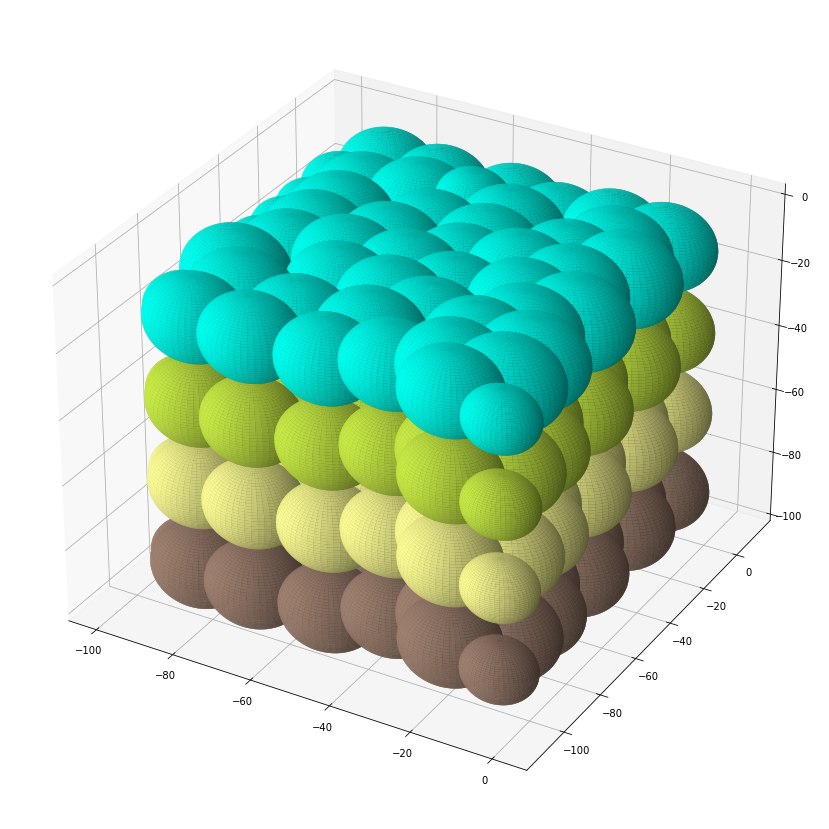

In [518]:
big_terrain.plotEdits()

In [519]:
big_terrain.evaluateEditsError()

For Block [0][0][0], 823272/1000000 points where successfully classified. Error: 17.6728%.


In [474]:
finalShaderString = "float smoothUnion(float a, float b) {\n    float k = 0.1;\n float h = max( k-abs(a-b), 0.0 )/k;\nreturn min( a, b ) - h*h*k*(1.0/4.0); }\nfloat sphereSDF(vec3 p, vec3 pos, float r) { return length(pos - p) - r; }\n\n"
finalShaderString = finalShaderString + generateShader(spheres, 1)
print(finalShaderString)

float smoothUnion(float a, float b) {
    float k = 0.1;
 float h = max( k-abs(a-b), 0.0 )/k;
return min( a, b ) - h*h*k*(1.0/4.0); }
float sphereSDF(vec3 p, vec3 pos, float r) { return length(pos - p) - r; }

float soil1SDF(vec3 inputPoint) {
return smoothUnion(sphereSDF(inputPoint, vec3(16.0, 91.0, 50.0), 9.0), smoothUnion(sphereSDF(inputPoint, vec3(16.0, 91.0, 37.0), 9.0), smoothUnion(sphereSDF(inputPoint, vec3(16.0, 91.0, 24.0), 9.0), smoothUnion(sphereSDF(inputPoint, vec3(8.0, 56.0, 10.0), 9.0), smoothUnion(sphereSDF(inputPoint, vec3(15.0, 8.0, 99.0), 9.0), smoothUnion(sphereSDF(inputPoint, vec3(15.0, 90.0, 90.0), 10.0), smoothUnion(sphereSDF(inputPoint, vec3(15.0, 90.0, 10.0), 10.0), smoothUnion(sphereSDF(inputPoint, vec3(13.0, 25.0, 0.0), 12.0), smoothUnion(sphereSDF(inputPoint, vec3(11.0, 20.0, 99.0), 12.0), smoothUnion(sphereSDF(inputPoint, vec3(13.0, 12.0, 0.0), 12.0), smoothUnion(sphereSDF(inputPoint, vec3(13.0, 50.0, 0.0), 12.0), smoothUnion(sphereSDF(inputPoint, vec3(12.0,

In [4]:
# Que hacemos actualmente?
# Separamos 4 rangos de densidades. Calculamos 4 veces la sdf para cada densidad. Todas sobre el mismo sector del espacio.
# Para escalar esto: 
#   Separamos en octantes formando un kdtree que lo recorremos para obtener mayor detalle. Cada octante contiene las 4 sdfs distintas.
#   Cada sdf tiene asignado un color desde el shader.
#   Como solucionar la union suave entre sdfs dentro de un mismo octante? Si toca a otra sdf entonces lo pintamos como la interpolacion de las dos sdfs.
#   Como solucionar la union suave entre fronteras de octantes? Podemos hacer que las esferas engloben la frontera, y el otro lado lo va a llenar igual.
#     O. Podemos hacer un smooth union de los 3 cubos cercanos del lado de la frontera que choca. 


# !! Guarda el tema de la escala en las distintas sdfs. 

# Calcular el error generado con media cuadratica. 